# Olivine Diffusion - 2
## Solution Space Exploration and Advanced Optimization

*Course: Advanced Data Analysis in Geochemistry - Part 2*  
(c) Charles Le Losq

---

## Learning Objectives

By the end of this notebook, you should understand:

1. Why local optimization algorithms can fail
2. How to visualize and analyze objective function landscapes in parameter space
3. The differences between optimization criteria (L2 vs L1 norms)
4. Global optimization strategies for complex problems
5. Parameter correlation effects and their impact on fitting
6. Practical strategies for robust parameter estimation

## The Challenge: Why Our Fitting Can Fail?

Even with "smart" initial guesses, nonlinear regression can be challenging. To understand why, we need to examine the **topology of the objective function** - the "landscape" that optimization algorithms must navigate.

### **Key Questions:**
- What does the parameter space look like?
- Where are the local minima vs. the global minimum?
- How do parameter correlations affect optimization?
- What strategies can overcome these challenges?

## Theoretical Background

**Nonlinear least squares** seeks to minimize:
$
\begin{align}
S(\mathbf{p}) = \sum_{i=1}^{n} \left[\frac{y_i - f(x_i, \mathbf{p})}{\sigma_i}\right]^2
\end{align}
$

Where:
- $\mathbf{p} = [D, c_{rim}, c_{bg}]$ are our parameters
- $f(x_i, \mathbf{p})$ is our diffusion model
- $\sigma_i$ are the measurement uncertainties

**Gradient-based algorithms** (like those in `curve_fit`) use:
$
\begin{align}
\mathbf{p}_{k+1} = \mathbf{p}_k - \alpha \nabla S(\mathbf{p}_k)
\end{align}
$

This works well when $S(\mathbf{p})$ is:
- Convex (single minimum)
- Smooth (continuous derivatives)  
- Well-conditioned (similar curvatures in all directions)

Some geochemical problems can violate these assumptions!

## Approach: Systematic Parameter Space Exploration

We'll map the objective function systematically to understand:
1. 1D slices through parameter space
2. 2D contour maps of the objective function
3. Parameter correlation structures
4. Alternative optimization criteria

This diagnostic approach is essential for reliable geochemical data analysis.

=== Synthetic data reproduction ===
Data generated: 50 points
True parameters: D = -14.5, c0 = 100.0
Noise level: ~ 10 % of concentration or 5 ppm minimum


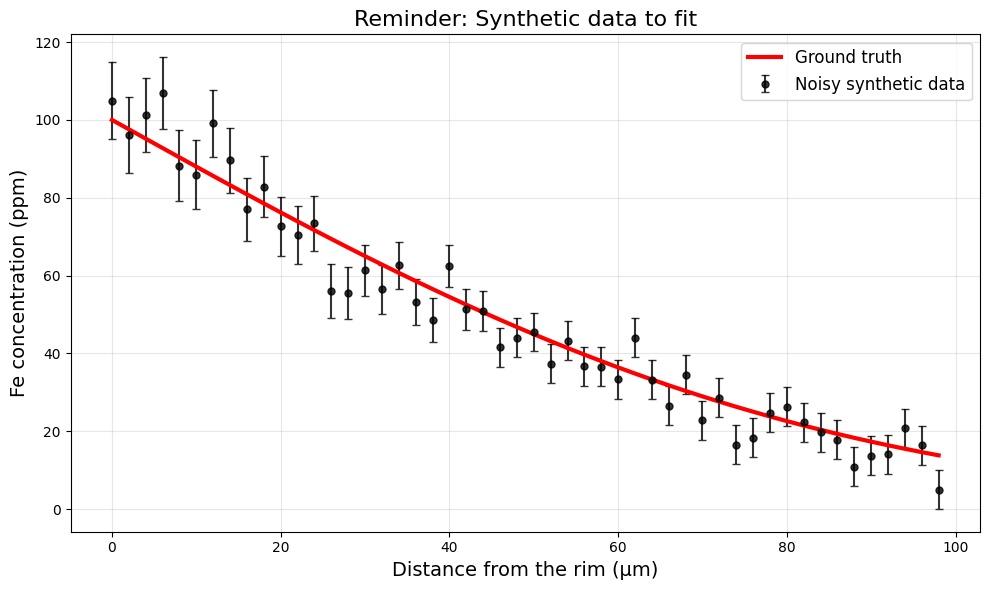


➜ Now, let's explore why optimization can fail...


In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)  # Reproducibility
import pandas as pd
import scipy
from scipy.optimize import curve_fit
from scipy.special import erfc

def forward_model(x, D, c0):
    """Forward model: 1D solution of Fick diffusion
    
    Parameters
    ----------
    x : array_like
        distance in micrometers
    D : float
        diffusion coefficient in log10 m² s⁻¹
    c0 : float
        concentration at the boundary in ppm
        
    Returns
    -------
    c : array_like
        concentration at distance x
    """
    t = 192.0 * 3600  # time fixed here (192 h in seconds)
    return c0 * erfc(x * 1e-6 / (2 * np.sqrt(10**D * t)))

# Regenerate synthetic data identical to notebook 1
print("=== Synthetic data reproduction ===")

x_synthetic = np.arange(0, 100, 2.0)  # micrometers
D_synthetic = -14.5   # log10 m² s⁻¹ ("true" parameter)
c0_synthetic = 100.0  # ppm ("true" parameter)

y_synthetic = forward_model(x_synthetic, D_synthetic, c0_synthetic)

# Add the same noise as before
ese_synthetic = np.maximum(0.1 * y_synthetic, 5.0)
noise_synthetic = np.random.randn(len(x_synthetic)) * ese_synthetic
y_synthetic_noisy = y_synthetic + noise_synthetic

print(f"Data generated: {len(x_synthetic)} points")
print(f"True parameters: D = {D_synthetic}, c0 = {c0_synthetic}")
print(f"Noise level: ~ 10 % of concentration or 5 ppm minimum")

# Visualization reminder
plt.figure(figsize=(10, 6))
plt.errorbar(x_synthetic, y_synthetic_noisy, yerr=ese_synthetic,
             fmt="ko", capsize=3, capthick=1, markersize=5,
             label="Noisy synthetic data", alpha=0.8)
plt.plot(x_synthetic, y_synthetic, "r-", linewidth=3, 
         label="Ground truth")

plt.xlabel("Distance from the rim (µm)", fontsize=14)
plt.ylabel("Fe concentration (ppm)", fontsize=14)
plt.title("Reminder: Synthetic data to fit", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n➜ Now, let's explore why optimization can fail...")

## 1D Exploration

Let's start by understanding how the objective function varies as a function of a single parameter. For this test, we will vary D, and fixe c0 to its true value. 

We will visualize how the Least squares objective function:

$
\begin{align}
\text{misfit} = \sum_{i=1}^{n} (d_i - m_i)^2
\end{align}
$

changes as D varies. 

This exploration will allow us to:
1. Visualize the "topography" of the solution space
2. Identify the location of the global minimum
3. Understand why local algorithms can fail


1D exploration results:
Optimal D found: -14.55 (true: -14.5)
Error on D: 0.050
Minimum misfit value: 1601.6


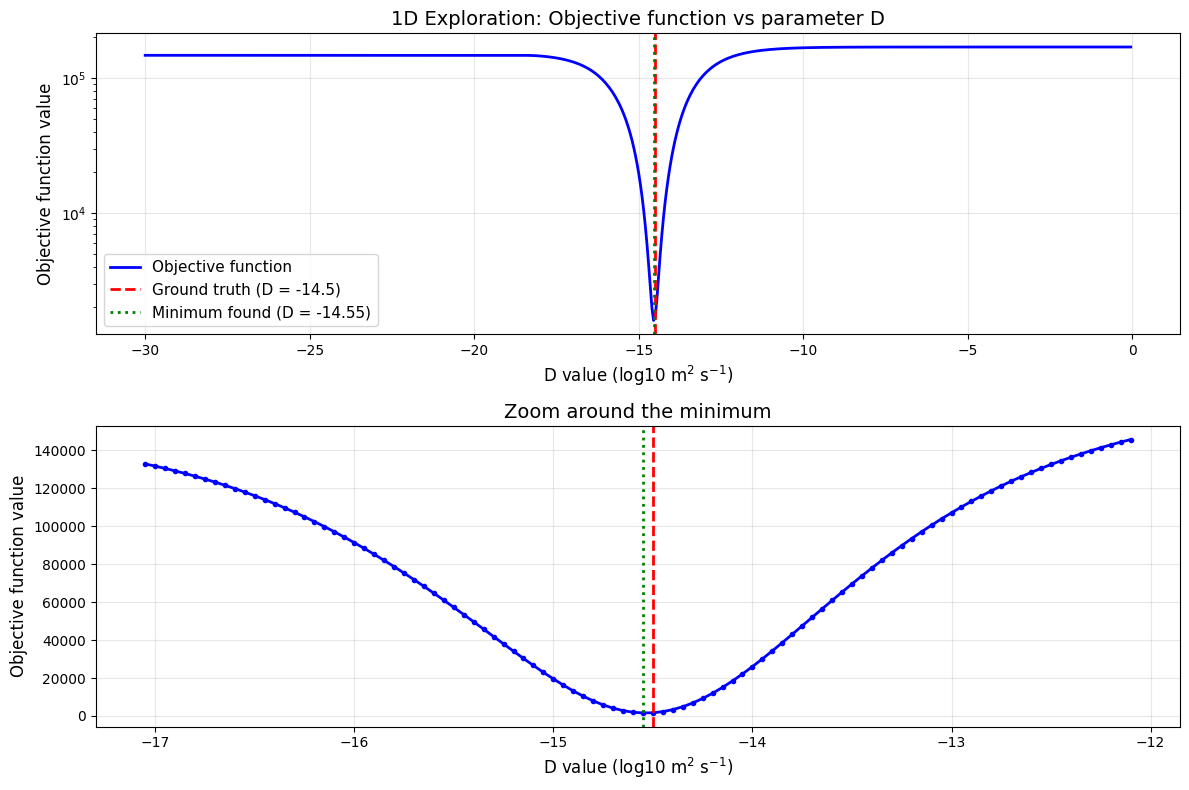


=== Objective function analysis ===
Gradient at minimum: -2.73e+03
Curvature at minimum: 1.92e+05


In [5]:
# Define the objective function
def least_square_criterion(y_measured, y_calculated):
    """Least squares criterion"""
    return np.sum((y_measured - y_calculated)**2)

# Define exploration range for D
D_range = np.arange(-30.0, 0.0, 0.05)  # Wide range to see the behavior well
n_evaluations = len(D_range)

# Calculate objective function for each D value
misfit_values = np.zeros(len(D_range))

for i, D_test in enumerate(D_range):
    # model predictions & objective function calculation
    y_calculated = forward_model(x_synthetic, D_test, c0_synthetic)
    misfit_values[i] = least_square_criterion(y_synthetic_noisy, y_calculated)

# Identify the minimum
min_idx = np.argmin(misfit_values)
D_optimal_1d = D_range[min_idx]
misfit_min = misfit_values[min_idx]

print(f"\n1D exploration results:")
print(f"Optimal D found: {D_optimal_1d:.2f} (true: {D_synthetic})")
print(f"Error on D: {abs(D_optimal_1d - D_synthetic):.3f}")
print(f"Minimum misfit value: {misfit_min:.1f}")

# Objective function visualization
plt.figure(figsize=(12, 8))

# Main plot
plt.subplot(2, 1, 1)
plt.plot(D_range, misfit_values, 'b-', linewidth=2, label='Objective function')
plt.axvline(D_synthetic, color='red', linestyle='--', linewidth=2, 
           label=f'Ground truth (D = {D_synthetic})')
plt.axvline(D_optimal_1d, color='green', linestyle=':', linewidth=2,
           label=f'Minimum found (D = {D_optimal_1d:.2f})')

plt.xlabel("D value (log10 m$^2$ s$^{-1}$)", fontsize=12)
plt.ylabel("Objective function value", fontsize=12)
plt.title("1D Exploration: Objective function vs parameter D", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Log scale to better see the structure

# Zoom around the minimum
plt.subplot(2, 1, 2)
# Select a window around the minimum
window = 50
start_idx = max(0, min_idx - window)
end_idx = min(len(D_range), min_idx + window)

plt.plot(D_range[start_idx:end_idx], misfit_values[start_idx:end_idx], 
         'b-', linewidth=2, marker='o', markersize=3)
plt.axvline(D_synthetic, color='red', linestyle='--', linewidth=2)
plt.axvline(D_optimal_1d, color='green', linestyle=':', linewidth=2)

plt.xlabel("D value (log10 m$^2$ s$^{-1}$)", fontsize=12)
plt.ylabel("Objective function value", fontsize=12)
plt.title("Zoom around the minimum", fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Objective function shape analysis
gradient_approx = np.gradient(misfit_values, D_range)
curvature_approx = np.gradient(gradient_approx, D_range)

print(f"\n=== Objective function analysis ===")
print(f"Gradient at minimum: {gradient_approx[min_idx]:.2e}")
print(f"Curvature at minimum: {curvature_approx[min_idx]:.2e}")

## Alternative Optimization Criteria

The choice of objective function profoundly affects both the optimization landscape and the final results. Let's compare the standard **least squares** (L2) with **least absolute deviations** (L1).

### **Least Squares (L2 norm):**
$
\begin{align}
S_{L2} = \sum_{i=1}^{n} \left(y_i - f(x_i, \mathbf{p})\right)^2
\end{align}
$

**Properties:**
- ✅ Differentiable everywhere → efficient gradient-based optimization
- ✅ Maximum likelihood estimator for Gaussian noise
- ✅ Unique global minimum for linear problems
- ⚠️ Sensitive to outliers (quadratic penalty)
- ⚠️ Assumes homoscedastic, Gaussian errors

### **Least Absolute Deviations (L1 norm):**
$
\begin{align}
S_{L1} = \sum_{i=1}^{n} |y_i - f(x_i, \mathbf{p})|
\end{align}
$

**Properties:**
- ✅ Robust to outliers (linear penalty)
- ✅ Maximum likelihood estimator for Laplacian noise
- ✅ More robust to model misspecification
- ⚠️ Non-differentiable at residual = 0
- ⚠️ Can have multiple equivalent solutions
- ⚠️ Requires specialized optimization algorithms

### **General recommendations:**

**Use L2 when:**
- Measurement errors are well-characterized and Gaussian
- No significant outliers expected
- Model is appropriate for the data
- Want to minimize variance in parameter estimates

**Use L1 when:**
- Suspect outliers or non-Gaussian noise
- Model may have systematic deviations
- Want robust parameter estimates
- Working with limited, high-precision data

**Hybrid approaches:**
- Huber loss: Combines L2 (small residuals) and L1 (large residuals)  
- Weighted least squares: Account for heteroscedastic errors
- Iteratively reweighted least squares: Adaptive robustness

Least squares (L2) minimum: D = -14.550
Least deviations (L1) minimum: D = -14.550
Difference between the two: 0.000


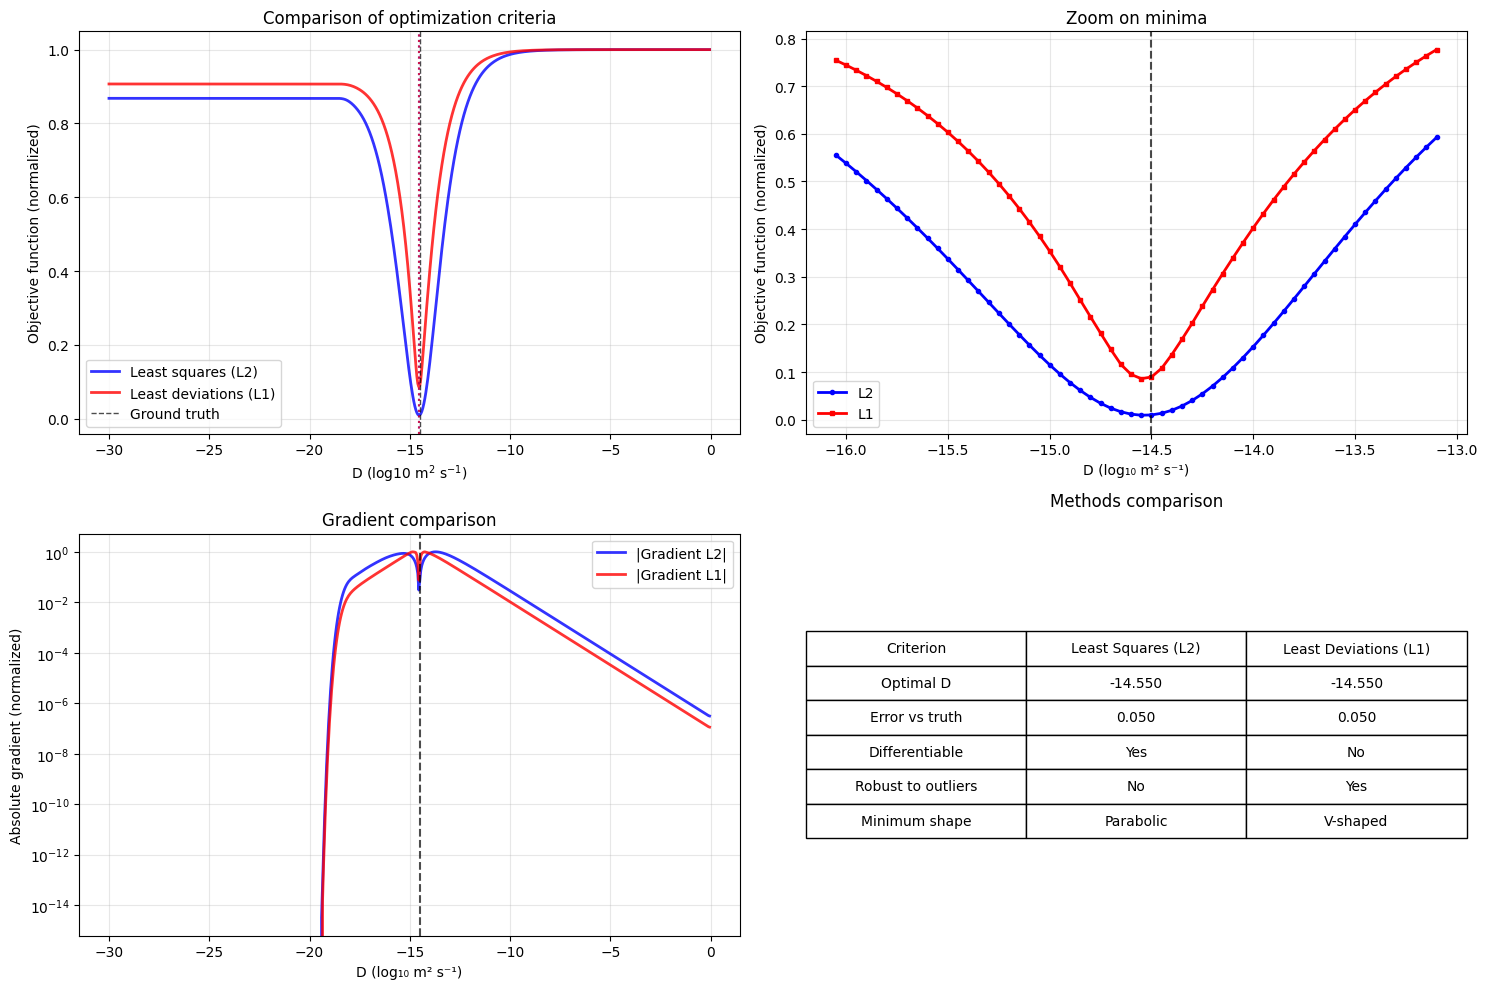


=== Comments ===
1. Both criteria give similar results for these data
2. L1 is more robust to outliers but non-differentiable
3. L2 has a 'smoother' shape facilitating gradient-based optimization
4. The choice depends on noise type and data assumptions


In [6]:
# Comparison of optimization criteria
def least_absolute_criterion(y_measured, y_calculated):
    """Least absolute deviations criterion (L1)"""
    return np.sum(np.abs(y_measured - y_calculated))

# Calculations for LAD criterion
misfit_lad_values = np.zeros(len(D_range))

for i, D_test in enumerate(D_range):
    y_calculated = forward_model(x_synthetic, D_test, c0_synthetic)
    misfit_lad_values[i] = least_absolute_criterion(y_synthetic_noisy, y_calculated)

# Identify minima
min_idx_ls = np.argmin(misfit_values)
min_idx_lad = np.argmin(misfit_lad_values)

D_optimal_ls = D_range[min_idx_ls]
D_optimal_lad = D_range[min_idx_lad]

print(f"Least squares (L2) minimum: D = {D_optimal_ls:.3f}")
print(f"Least deviations (L1) minimum: D = {D_optimal_lad:.3f}")
print(f"Difference between the two: {abs(D_optimal_ls - D_optimal_lad):.3f}")

# Comparative visualization
plt.figure(figsize=(15, 10))

# Comparison of objective functions
plt.subplot(2, 2, 1)
plt.plot(D_range, misfit_values / np.max(misfit_values), 'b-', linewidth=2, 
         label='Least squares (L2)', alpha=0.8)
plt.plot(D_range, misfit_lad_values / np.max(misfit_lad_values), 'r-', linewidth=2, 
         label='Least deviations (L1)', alpha=0.8)

plt.axvline(D_synthetic, color='black', linestyle='--', linewidth=1, alpha=0.7,
           label='Ground truth')
plt.axvline(D_optimal_ls, color='blue', linestyle=':', alpha=0.7)
plt.axvline(D_optimal_lad, color='red', linestyle=':', alpha=0.7)

plt.xlabel("D (log10 m$^{2}$ s$^{-1}$)")
plt.ylabel("Objective function (normalized)")
plt.title("Comparison of optimization criteria")
plt.legend()
plt.grid(True, alpha=0.3)

# Zoom around minima
plt.subplot(2, 2, 2)
zoom_range = slice(max(0, min(min_idx_ls, min_idx_lad) - 30), 
                  min(len(D_range), max(min_idx_ls, min_idx_lad) + 30))

plt.plot(D_range[zoom_range], misfit_values[zoom_range] / np.max(misfit_values), 
         'b-', linewidth=2, marker='o', markersize=3, label='L2')
plt.plot(D_range[zoom_range], misfit_lad_values[zoom_range] / np.max(misfit_lad_values), 
         'r-', linewidth=2, marker='s', markersize=3, label='L1')

plt.axvline(D_synthetic, color='black', linestyle='--', alpha=0.7)
plt.xlabel("D (log₁₀ m² s⁻¹)")
plt.ylabel("Objective function (normalized)")
plt.title("Zoom on minima")
plt.legend()
plt.grid(True, alpha=0.3)

# Gradient analysis
plt.subplot(2, 2, 3)
grad_ls = np.gradient(misfit_values, D_range)
grad_lad = np.gradient(misfit_lad_values, D_range)

plt.plot(D_range, np.abs(grad_ls) / np.max(np.abs(grad_ls)), 'b-', 
         linewidth=2, label='|Gradient L2|', alpha=0.8)
plt.plot(D_range, np.abs(grad_lad) / np.max(np.abs(grad_lad)), 'r-', 
         linewidth=2, label='|Gradient L1|', alpha=0.8)

plt.axvline(D_synthetic, color='black', linestyle='--', alpha=0.7)
plt.xlabel("D (log₁₀ m² s⁻¹)")
plt.ylabel("Absolute gradient (normalized)")
plt.title("Gradient comparison")
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Comparative table
plt.subplot(2, 2, 4)
plt.axis('off')

# Calculate some metrics
robustness_ls = np.std(misfit_values)
robustness_lad = np.std(misfit_lad_values)

comparison_data = [
    ["Criterion", "Least Squares (L2)", "Least Deviations (L1)"],
    ["Optimal D", f"{D_optimal_ls:.3f}", f"{D_optimal_lad:.3f}"],
    ["Error vs truth", f"{abs(D_optimal_ls - D_synthetic):.3f}", 
     f"{abs(D_optimal_lad - D_synthetic):.3f}"],
    ["Differentiable", "Yes", "No"],
    ["Robust to outliers", "No", "Yes"],
    ["Minimum shape", "Parabolic", "V-shaped"]
]

table = plt.table(cellText=comparison_data[1:], colLabels=comparison_data[0],
                 loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.8)
plt.title("Methods comparison", pad=20)

plt.tight_layout()
plt.show()

print(f"\n=== Comments ===")
print("1. Both criteria give similar results for these data")
print("2. L1 is more robust to outliers but non-differentiable")
print("3. L2 has a 'smoother' shape facilitating gradient-based optimization")
print("4. The choice depends on noise type and data assumptions")

## 2D Exploration : Visualization of the parameter space

We have three parameters, so our objective function is a 3D surface. We can have a look at it in a 2D space, focusing on two parameters. 

**Important questions :**
- Is there correlation between parameters?
- Is the shape of the optimization parameter Gaussian, or more complex?
- Where are located the local minima versus the global minimum?

Exploration grid : 50 × 50 = 2500 evaluations
D in [-20.0, -10.200000000000035]
c0 in [50.0, 148.0]
Calculating... (this may take a few seconds)
Progress: 24%
Progress: 48%
Progress: 72%
Progress: 96%

=== 2D exploration results ===
True parameters : D = -14.5, c0 = 100.0
L2 optimum : D = -14.60, c0 = 104.0
L1 optimum : D = -14.60, c0 = 106.0


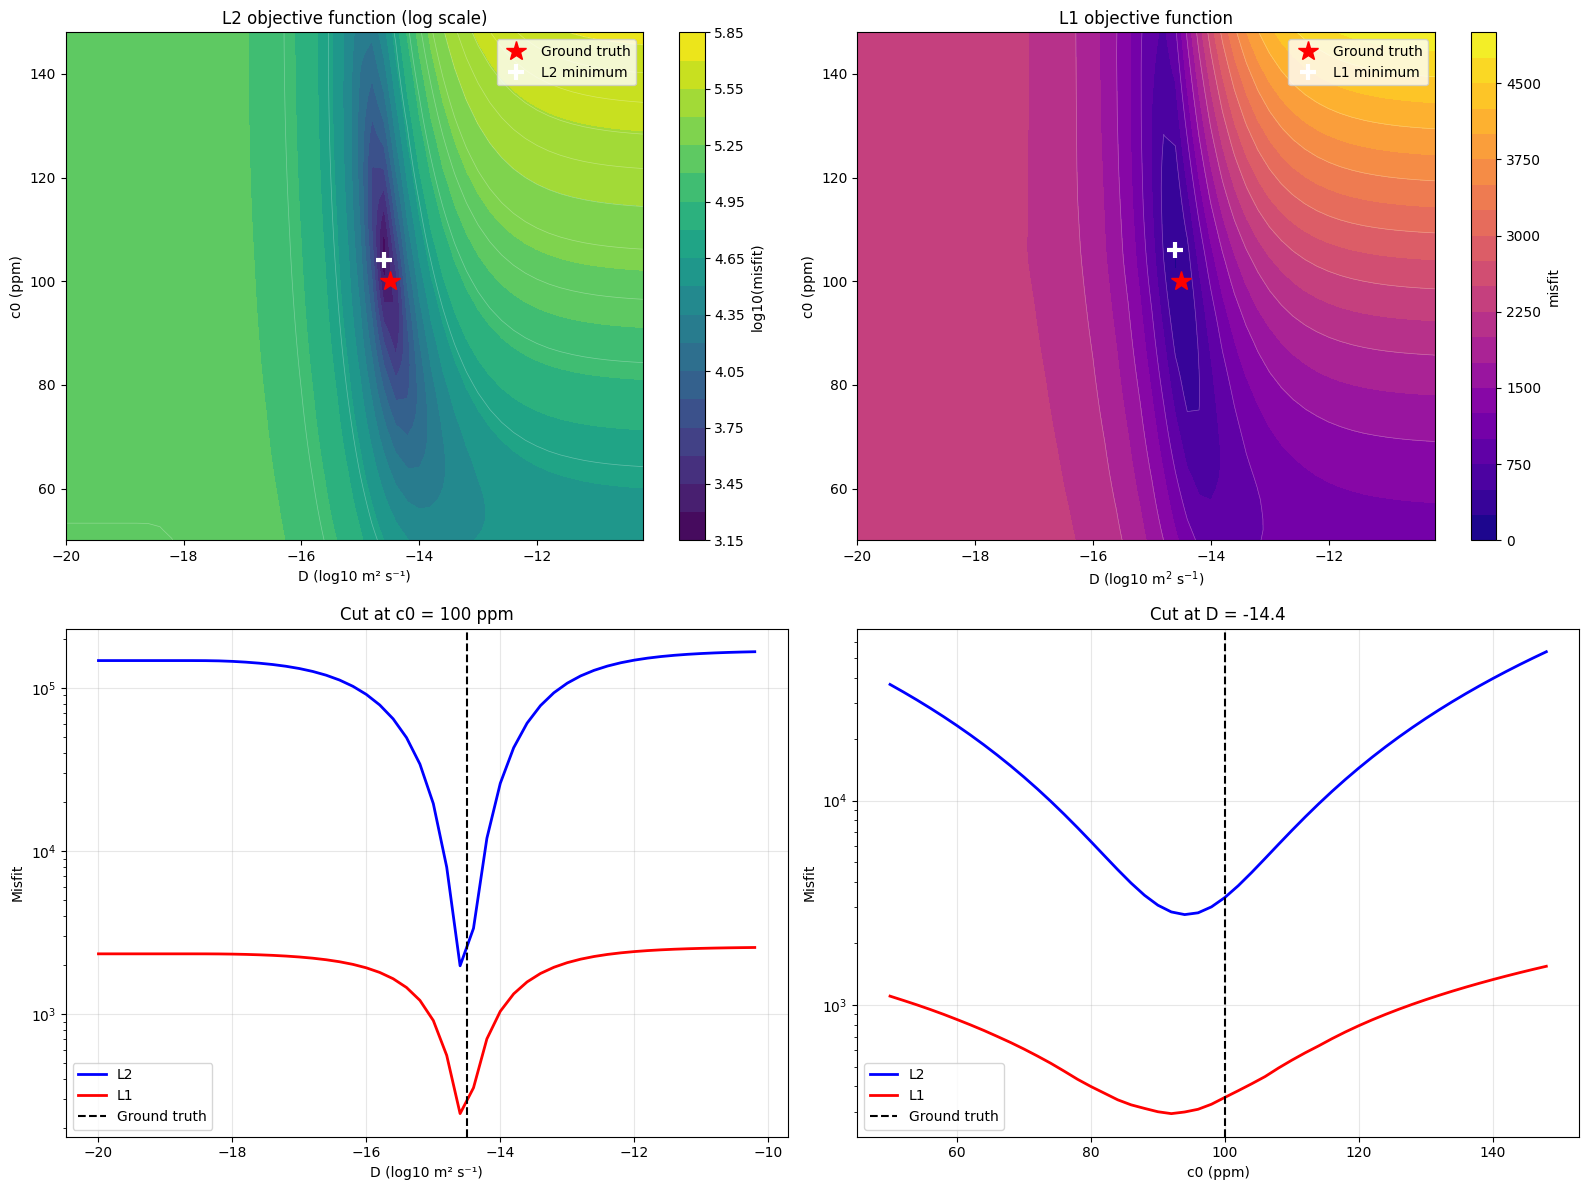


=== Complexity analysis ===
Minimum L2 value: 1639.5
Minimum L1 value: 234.6
L2 max/min ratio: 3.2e+02
Exploration space aspect ratio: 0.100

=> Important observations for optimization :
1. The objective function shape is complex and elongated
2. There can be significant correlations between D and c0
3. Gradients can be very small far from the minimum
4. Local algorithms may converge slowly or fail


In [8]:
# Exploration range for D and c0
D_range_2d = np.arange(-20.0, -10.0, 0.2) 
c0_range = np.arange(50, 150.0, 2.0)   

print(f"Exploration grid : {len(D_range_2d)} × {len(c0_range)} = {len(D_range_2d)*len(c0_range)} evaluations")
print(f"D in [{D_range_2d[0]}, {D_range_2d[-1]}]")
print(f"c0 in [{c0_range[0]}, {c0_range[-1]}]")

# Compute objective function on the 2D grid
nb_D = len(D_range_2d)
nb_c0 = len(c0_range)

LS_OF = np.zeros((nb_D, nb_c0))   # Least squares
LAD_OF = np.zeros((nb_D, nb_c0))  # Least absolute deviations

print("Calculating... (this may take a few seconds)")

for i, D_val in enumerate(D_range_2d):
    for j, c0_val in enumerate(c0_range):
        y_calculated = forward_model(x_synthetic, D_val, c0_val)
        LS_OF[i, j] = least_square_criterion(y_synthetic_noisy, y_calculated)
        LAD_OF[i, j] = least_absolute_criterion(y_synthetic_noisy, y_calculated)
    
    # Progress display
    if (i + 1) % (nb_D // 4) == 0:
        print(f"Progress: {(i+1)/nb_D*100:.0f}%")

# Identify global minima
min_idx_ls_2d = np.unravel_index(np.argmin(LS_OF), LS_OF.shape)  
min_idx_lad_2d = np.unravel_index(np.argmin(LAD_OF), LAD_OF.shape)

D_optimal_ls_2d = D_range_2d[min_idx_ls_2d[0]]
c0_optimal_ls_2d = c0_range[min_idx_ls_2d[1]]

D_optimal_lad_2d = D_range_2d[min_idx_lad_2d[0]]
c0_optimal_lad_2d = c0_range[min_idx_lad_2d[1]]

print(f"\n=== 2D exploration results ===")
print(f"True parameters : D = {D_synthetic}, c0 = {c0_synthetic}")
print(f"L2 optimum : D = {D_optimal_ls_2d:.2f}, c0 = {c0_optimal_ls_2d:.1f}")
print(f"L1 optimum : D = {D_optimal_lad_2d:.2f}, c0 = {c0_optimal_lad_2d:.1f}")

# Surface visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Create grids for display
D_grid, c0_grid = np.meshgrid(D_range_2d, c0_range, indexing='ij')

# L2 surface - contours
im1 = axes[0,0].contourf(D_grid, c0_grid, np.log10(LS_OF), levels=20, cmap='viridis')
axes[0,0].contour(D_grid, c0_grid, LS_OF, levels=10, colors='white', alpha=0.3, linewidths=0.5)
axes[0,0].plot(D_synthetic, c0_synthetic, 'r*', markersize=15, label='Ground truth')
axes[0,0].plot(D_optimal_ls_2d, c0_optimal_ls_2d, 'w+', markersize=12, markeredgewidth=3, label='L2 minimum')
axes[0,0].set_xlabel("D (log10 m² s⁻¹)")
axes[0,0].set_ylabel("c0 (ppm)")
axes[0,0].set_title("L2 objective function (log scale)")
axes[0,0].legend()
plt.colorbar(im1, ax=axes[0,0], label='log10(misfit)')

# L1 surface - contours  
im2 = axes[0,1].contourf(D_grid, c0_grid, LAD_OF, levels=20, cmap='plasma')
axes[0,1].contour(D_grid, c0_grid, LAD_OF, levels=10, colors='white', alpha=0.3, linewidths=0.5)
axes[0,1].plot(D_synthetic, c0_synthetic, 'r*', markersize=15, label='Ground truth')
axes[0,1].plot(D_optimal_lad_2d, c0_optimal_lad_2d, 'w+', markersize=12, markeredgewidth=3, label='L1 minimum')
axes[0,1].set_xlabel("D (log10 m$^2$ s$^{-1}$)")
axes[0,1].set_ylabel("c0 (ppm)")
axes[0,1].set_title("L1 objective function")
axes[0,1].legend()
plt.colorbar(im2, ax=axes[0,1], label='misfit')

# 1D cuts through the minima
# Cut at fixed c0
c0_idx_true = np.argmin(np.abs(c0_range - c0_synthetic))
axes[1,0].plot(D_range_2d, LS_OF[:, c0_idx_true], 'b-', linewidth=2, label='L2')
axes[1,0].plot(D_range_2d, LAD_OF[:, c0_idx_true], 'r-', linewidth=2, label='L1')
axes[1,0].axvline(D_synthetic, color='black', linestyle='--', label='Ground truth')
axes[1,0].set_xlabel("D (log10 m² s⁻¹)")
axes[1,0].set_ylabel("Misfit")
axes[1,0].set_title(f"Cut at c0 = {c0_range[c0_idx_true]:.0f} ppm")
axes[1,0].legend()
axes[1,0].set_yscale('log')
axes[1,0].grid(True, alpha=0.3)

# Cut at fixed D
D_idx_true = np.argmin(np.abs(D_range_2d - D_synthetic))
axes[1,1].plot(c0_range, LS_OF[D_idx_true, :], 'b-', linewidth=2, label='L2')
axes[1,1].plot(c0_range, LAD_OF[D_idx_true, :], 'r-', linewidth=2, label='L1')
axes[1,1].axvline(c0_synthetic, color='black', linestyle='--', label='Ground truth')
axes[1,1].set_xlabel("c0 (ppm)")
axes[1,1].set_ylabel("Misfit")
axes[1,1].set_title(f"Cut at D = {D_range_2d[D_idx_true]:.1f}")
axes[1,1].legend()
axes[1,1].set_yscale('log')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analysis of the solution space shape
print(f"\n=== Complexity analysis ===")

# Approximate correlation calculations
correlation_region = 5  # Region size around the minimum to analyze correlation
D_min_idx, c0_min_idx = min_idx_ls_2d

# Extract a region around the minimum
D_start = max(0, D_min_idx - correlation_region)
D_end = min(nb_D, D_min_idx + correlation_region)
c0_start = max(0, c0_min_idx - correlation_region)
c0_end = min(nb_c0, c0_min_idx + correlation_region)

region_LS = LS_OF[D_start:D_end, c0_start:c0_end]

print(f"Minimum L2 value: {np.min(LS_OF):.1f}")
print(f"Minimum L1 value: {np.min(LAD_OF):.1f}")
print(f"L2 max/min ratio: {np.max(LS_OF)/np.min(LS_OF):.1e}")

# Estimate the ellipticity of the minimum (aspect of the shape)
aspect_ratio = (D_range_2d[-1] - D_range_2d[0]) / (c0_range[-1] - c0_range[0])
print(f"Exploration space aspect ratio: {aspect_ratio:.3f}")

print(f"\n=> Important observations for optimization :")
print("1. The objective function shape is complex and elongated")  ,
print("2. There can be significant correlations between D and c0")
print("3. Gradients can be very small far from the minimum")
print("4. Local algorithms may converge slowly or fail")


## Why gradient-based algorithms can fail

In the figure above, you can see that the objective-function space exhibits features that are problematic for optimization:

### **Identified difficulties:**

1. **Elongated valleys** : The objective function forms narrow, elongated valleys
2. **Small gradients** : Far from the minimum, gradients are very small
3. **Parameter correlations** : D and c0 can be strongly correlated
4. **Plateaus** : Regions where the function changes little

### **Implications for optimization:**

**Gradient-based methods compute:**
$
\begin{align}
\frac{\partial S}{\partial c_0} \quad \text{and} \quad \frac{\partial S}{\partial D}
\end{align}
$


and take small iterative steps toward the minimum.

**Potential problems:**
- Slow convergence : small gradients -> very small steps
- Local minima : the algorithm can get "stuck"
- Sensitivity to initialization: the starting point often determines the outcome
- High condition number: large ratio between principal curvatures

### **Proposed solutions in the following sections:**

1. ✅ Smart parameter initialization
2. ✅ Global algorithms (non–gradient-based)
3. ✅ Alternative objective functions (L1 vs L2)

# Advanced Solutions for Optimization Challenges

Having diagnosed the potential problems with parameter space topology, we now implement robust solutions. We will progress through increasingly sophisticated approaches.

## Intelligent Parameter Initialization & Weighted Least Squares

Default initial guesses (usually 1.0 for all parameters) are rarely appropriate. It is best to use physical/chemical insights and data characteristics to provide reasonable starting points. Also, if you have errors $\sigma$ on measurements, it is best to include them through weighted least squares:

$
\begin{align}
S_{L2} = \sum_{i=1}^{n} \left(\frac{y_i - f(x_i, \mathbf{p})}{\sigma_i}\right)^2
\end{align}
$

**Initial values of parameters** can come from the literature (e.g. for D), estimations from the data (e.g. for the concentrations), or even other thermodynamic models and complementary analysis.

**Advanced initialization strategies** can be used, including:
- Grid search: Try multiple starting points systematically
- Heuristic methods: Use simple linear fits for initial estimates
- Multi-stage fitting: Fit subsets of parameters sequentially
- Physical constraints: Impose reasonable bounds on parameters

Below we use coherent starting values for the parameters and compare weighted least squares  versus non-weighted least squares regression.

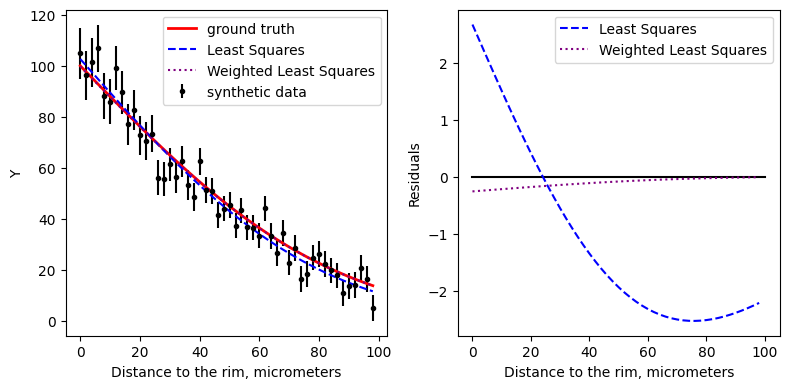


=> it is clear that weighted least squares provides a better fit to the data.


In [ ]:
# we need to import curve_fit for fitting our curve
# we also import uncertainties for error propagation
from scipy.optimize import curve_fit 

### MODIFY THE CODE BELOW TO SHOW THE ADVANTAGES OF WEIGHTED LEAST SQUARES ###

# Fit without weights (ordinary least squares)
popt, pcov = curve_fit(# COMPLETE THIS
    ) 

# Fit with weights (weighted least squares)
popt2, pcov2 = curve_fit(# COMPLETE THIS
    ) 

# Make a figure to compare both fits


## Global Optimization Algorithms

Gradient-based methods can get trapped in local minima and are sensitive to initialization. We can use algorithms designed for global search that do not rely on gradients.

Several algorithms can be cited:
- Genetic Algorithm
- Differential Evolution
- Simulated Annealing
- Particle Swarn
- Basin Hopping

Below we will see how we can use the differential evolution algorithm from the scipy.optimize library to solve the problem. It is not strictly necessary here, but at least you will know it exists and how to use it.

### **Differential Evolution Algorithm**

Differential Evolution (DE) is particularly well-suited for many problems:

**How it works:**
1. Initialize a population of candidate solutions randomly
2. For each candidate, create a mutant by combining other population members
3. Select the better solution (original vs. mutant) for the next generation
4. Repeat until convergence

**Key parameters:**
- `popsize`: Population size multiplier (default: 15)
- `atol/rtol`: Convergence tolerance
- `maxiter`: Maximum iterations
- `seed`: For reproducible results

**Advantages:**
- ✅ Population-based: Explores multiple regions simultaneously
- ✅ Gradient-free: Works with discontinuous/noisy objective functions  
- ✅ Global search: Less likely to get trapped in local minima
- ✅ Simple implementation: Few tuning parameters required
- ✅ Handles bounds: Natural incorporation of parameter constraints

### **Other algorithms**

The other optimization methods cited above have different advantages:

*Simulated Annealing:*
- Accepts worse solutions probabilistically
- "Temperature" parameter controls acceptance
- Good for highly multimodal functions

*Genetic Algorithm:*
- Mimics biological evolution
- Crossover and mutation operations
- Good for discrete optimization problems

*Particle Swarm Optimization:*
- Particles "swarm" toward optimal solutions
- Social and cognitive behavior components
- Fast convergence for continuous problems

*Basin Hopping:*
- Combines local optimization with random jumps
- Effective for functions with many local minima
- Available in `scipy.optimize.basinhopping`

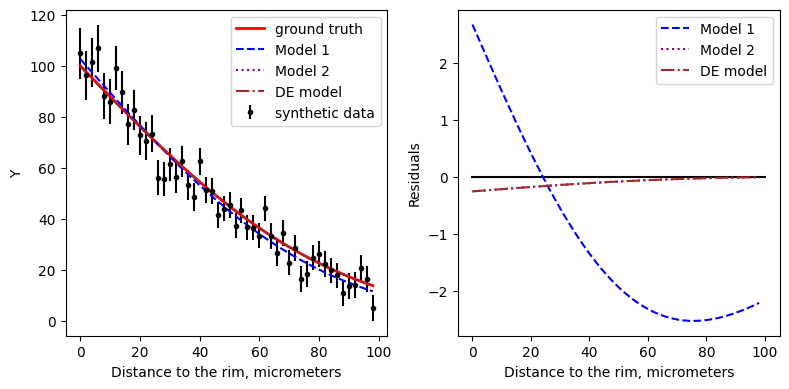

In [ ]:
from scipy.optimize import differential_evolution # we import the method here

def least_squares_objective(list_of_parameters, x, y, yerr=1.0):
    """the least square objective function"""
    model_values = forward_model(x, list_of_parameters[0], list_of_parameters[1])
    criterion = np.sum((y-model_values)**2/yerr**2) # ponderated least squares criterion
    return criterion

# we need to define a search space
# in the form of a list, containing sub-mlists of lower and upper bounds for the parameters

search_space = # --- COMPLETE THIS --- #

# Read the documentation for differential_evolution here:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html
# Complete the code below to perform differential evolution fitting
result_LS = differential_evolution(
    # --- COMPLETE THIS --- #
)

# --- MAKE A FIGURE --- #

### Use a different objective function

and a non-gradient base algorithm.

Actually we already did that, `differential_evolution` is not based on the calculation of the gradient. It is an evolutionary algorithm. For details, see the [Wikipedia page for instance](https://en.wikipedia.org/wiki/Differential_evolution)

Other algorithms are provided by scipy.minimize(), see help [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)

For simplicity, we will re-use the `differential_evolution` algorithm below to compare results from using the least square or least absolute deviation objective functions.

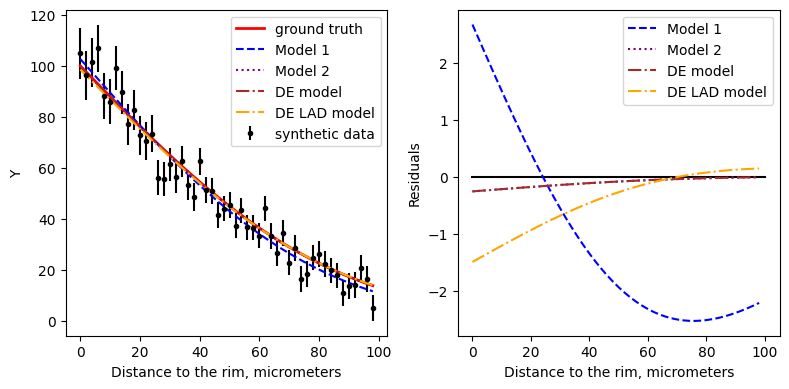

In [ ]:
def least_absolute_objective(list_of_parameters, x, y, yerr=1.0):
    # --- COMPLETE THIS --- #
    return criterion

# the fit using least absolute deviation
result_LAD = differential_evolution(
    # --- COMPLETE THIS --- #
)

# --- MAKE A FIGURE --- #

## Summary: Robust Optimization Strategies

### **What We've Learned in Notebook 2:**

1. **✅ Objective function topology**: Parameter spaces can be complex with multiple minima, valleys, and plateaus
2. **✅ Visualization techniques**: 1D slices and 2D contour maps reveal optimization challenges
3. **✅ Parameter correlations**: Strong correlations create elongated valleys that slow convergence
4. **✅ Optimization criteria**: L1 vs L2 norms have different properties and applications
5. **✅ Global optimization**: Differential Evolution and similar methods overcome local minima
6. **✅ Initialization strategies**: Physical insights guide better starting points

### **Key Insights:**

**When to use different approaches:**
- **Simple gradient methods**: Well-behaved problems with good initial guesses
- **Global optimization**: Complex parameter spaces, poor initial knowledge
- **L1 criteria**: Suspected outliers, robust parameter estimates needed
- **L2 criteria**: Well-characterized Gaussian errors, efficiency important

**Diagnostic workflow:**
1. **Explore parameter space** with 1D/2D visualizations
2. **Identify problematic regions** (flat areas, multiple minima)
3. **Choose appropriate optimization strategy** based on landscape
4. **Validate results** with multiple starting points or algorithms

### **The Remaining Challenge: Uncertainty Quantification**

Even with robust parameter estimation, critical questions remain:
- How reliable are our parameter estimates?
- What are the true uncertainties on diffusion coefficients?
- How do parameter uncertainties propagate to model predictions?
- Are covariance-based error bars trustworthy for complex problems?

**Answering those will be the topic of Notebook 3!**